# ARIMA Model Prototype

In [18]:
from omsapi import OMSAPI
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mplhep as hep

In [2]:
#The version of statsmodels is 0.10.2
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
omsapi = OMSAPI(api_url="https://vocms0185.cern.ch/agg/api", api_version="v1", cert_verify=False)
omsapi.auth_oidc("oms-api-client", "4577f6da-bbf7-4f5e-a898-f8db325e7e5e", audience="cmsoms-int-0185")

In [4]:
q=omsapi.query('datasetrates').paginate(page=1,per_page=1000).filter("run_number",315721).filter('dataset_name','SingleMuon')
response=q.data()
folded_json=response.json()

https://vocms0185.cern.ch/agg/api/v1/datasetrates/?filter[run_number][EQ]=315721&filter[dataset_name][EQ]=SingleMuon&page[offset]=0&page[limit]=1000


In [5]:
df=pd.json_normalize(folded_json['data'])
df.set_index('attributes.first_lumisection_number',inplace=True)
df=df[23:628]

In [19]:
plt.style.use([hep.style.ROOT,hep.style.firamath])

### Degree of difference 

In [61]:
df_change=df['attributes.rate'].diff()
rate_change=df_change.dropna()
rate_change

attributes.first_lumisection_number
34     173.999517
35      52.508730
36    -223.205001
37     -46.674427
38     127.196392
          ...    
634      0.000000
635      0.042899
636     -0.042899
637      0.042899
638      0.000000
Name: attributes.rate, Length: 604, dtype: float64

No handles with labels found to put in legend.


Text(0, 1, 'Rate(t) - Rate(t-1)')

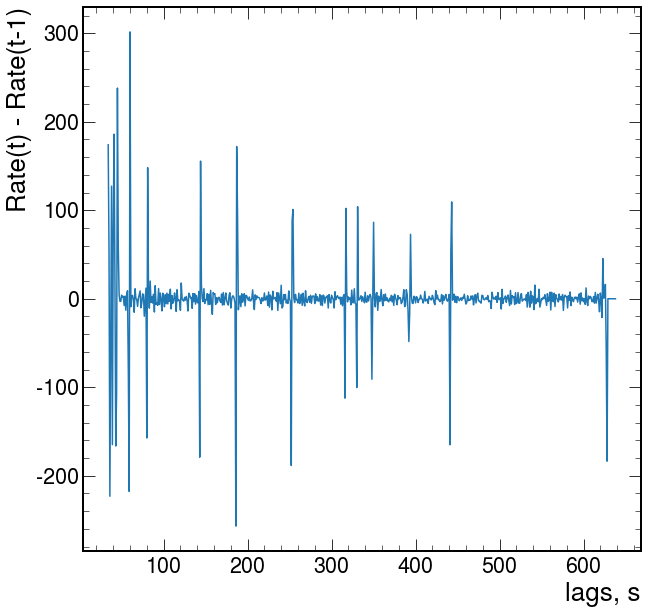

In [62]:
ax,f=plt.subplots(figsize=(10,10))
plt.plot(rate_change)
plt.legend()
plt.xlabel("lags, s")
plt.ylabel("Rate(t) - Rate(t-1)")

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


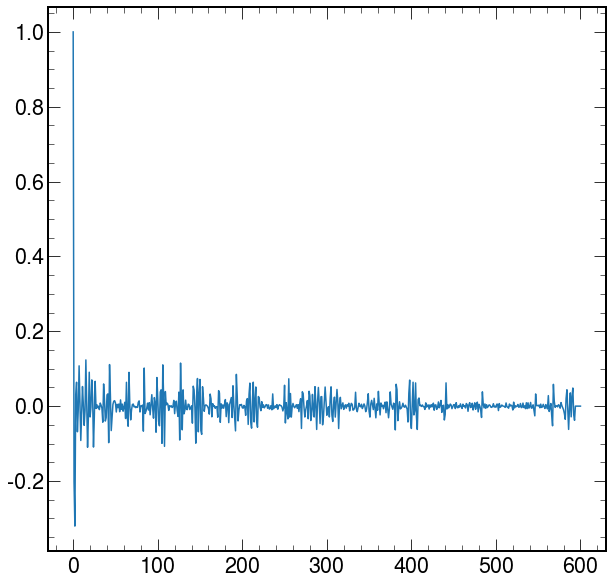

In [63]:
plt.plot(acf(rate_change,nlags=600))

### Autocorrelation and Partial autocorrelation plot

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


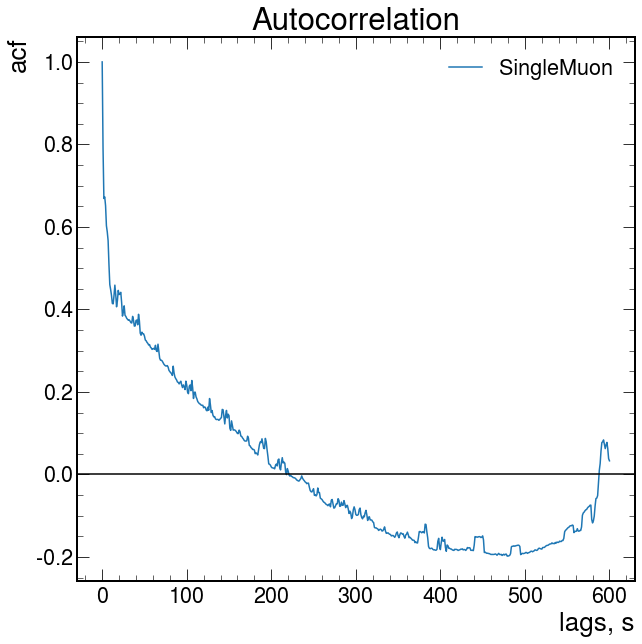

In [20]:
f,ax=plt.subplots(figsize=(10,10))
plt.plot(acf(df['attributes.rate'],nlags=600),label=df['attributes.dataset_name'][33])
plt.legend()
plt.title("Autocorrelation")
plt.xlabel("lags, s")
plt.ylabel("acf")
plt.axhline(color='black')

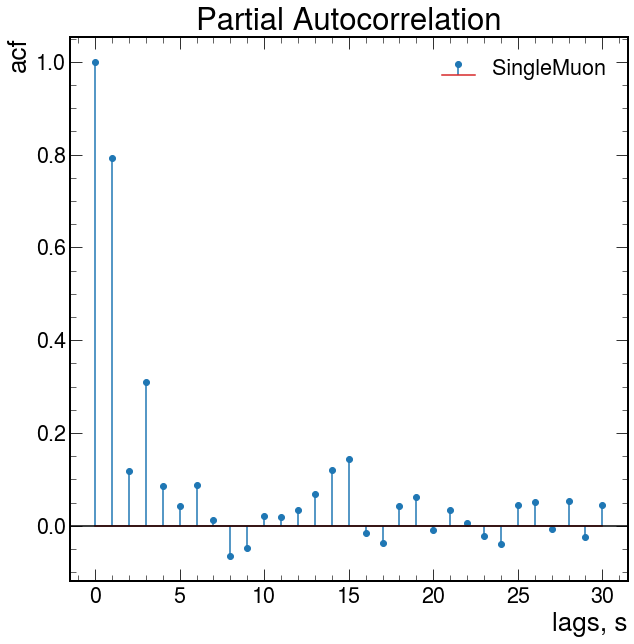

In [21]:
f,ax=plt.subplots(figsize=(10,10))
plt.stem(pacf(df['attributes.rate'],nlags=30),label=df['attributes.dataset_name'][33])
plt.legend()
plt.title("Partial Autocorrelation")
plt.xlabel("lags, s")
plt.ylabel("acf")
plt.axhline(color='black')

### Model Creation 

In [22]:
model=ARIMA(df['attributes.rate'],(2,1,0))
model_fit=model.fit(disp=0)

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [23]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D.attributes.rate   No. Observations:                  604
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2981.170
Method:                       css-mle   S.D. of innovations             33.665
Date:                Fri, 24 Jun 2022   AIC                           5970.340
Time:                        16:00:33   BIC                           5987.954
Sample:                             1   HQIC                          5977.195
                                                                              
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.3390      0.809     -0.419      0.675      -1.924       1.246
ar.L1.D.attributes.rate    -0.2972      0.038     -7.765      0.000      -0.372      -0.222
ar.L2.D.attributes.rate    -0.3983      0.038    -10.409      0.000      -0.473      -0.323
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3731           -1.5400j            1.5846           -0.2878
AR.2           -0.3731           +1.5400j            1.5846            0.2878
-----------------------------------------------------------------------------
"""

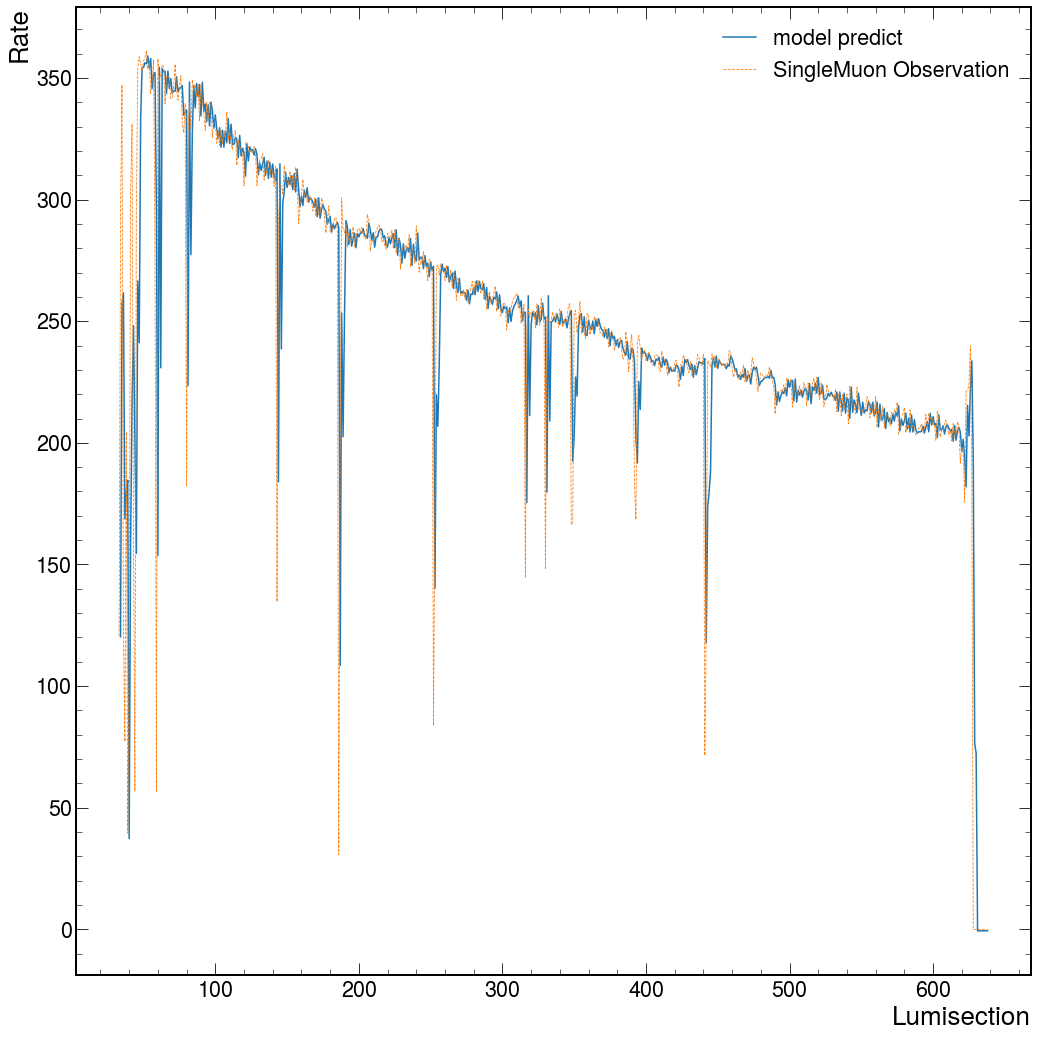

In [46]:
plt.subplots(figsize=(15,15))
model_predict=model_fit.predict(start=1,end=604,typ='levels')
plt.plot(model_predict,label='model predict')
plt.plot(df['attributes.rate'],ls='--',lw=0.8,label='SingleMuon Observation')
plt.legend()
plt.xlabel("Lumisection")
plt.ylabel("Rate")
plt.tight_layout()

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


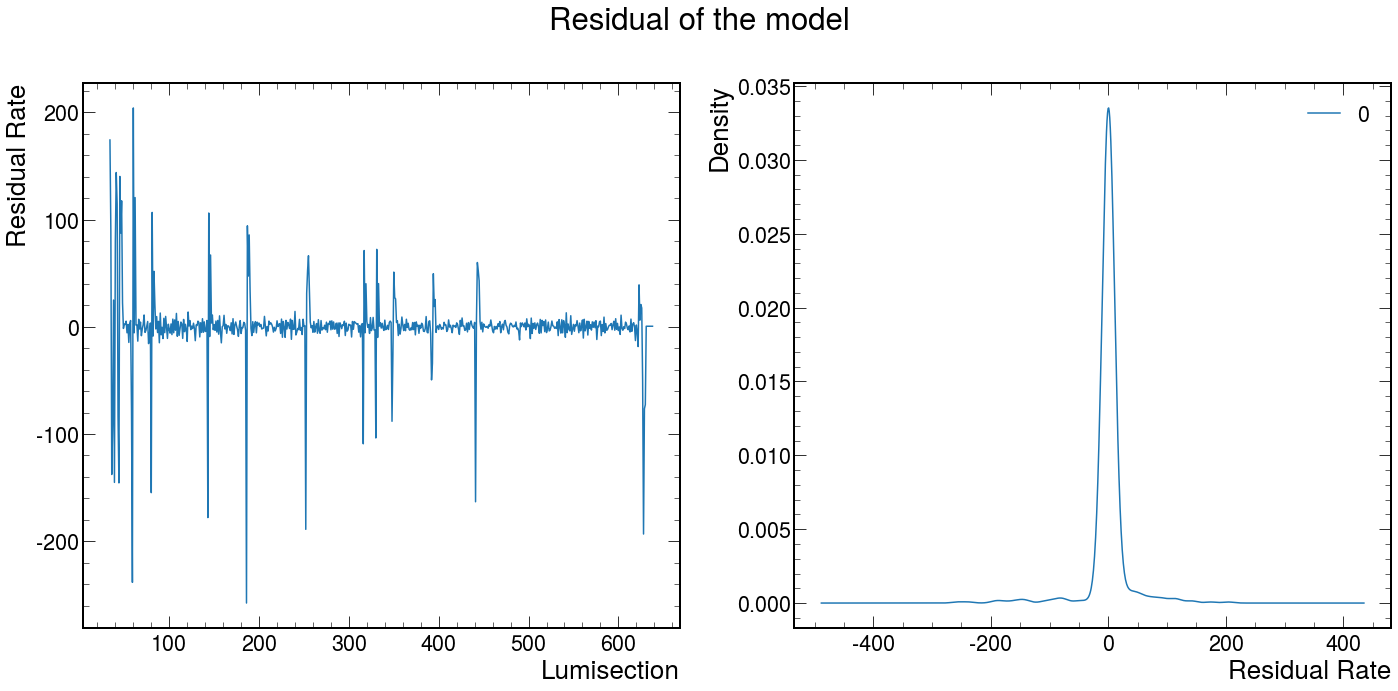

In [49]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
residual = pd.DataFrame(model_fit.resid)
ax1.plot(residual)
ax1.set_xlabel("Lumisection")
ax1.set_ylabel("Residual Rate")
residual.plot(ax=ax2,kind='kde')
ax2.set_xlabel("Residual Rate")
plt.suptitle("Residual of the model")
plt.tight_layout()

In [31]:
print("Residual description \n", residual.describe())

Residual description 
                 0
count  604.000000
mean     0.211150
std     33.870074
min   -257.674259
25%     -3.271525
50%      0.623048
75%      4.301106
max    204.228121
